# Lab on Stochastic Linear Bandits :

We provide the environment to run a standard linear bandit experiment. The objective of this lab session is to understand how to implement LinUCB, the algorithm seen in class and its variant LinTS. We shall see that in practice there are some shortcomings in the implementation to make it efficient so we will guide you to obtain a working version.

Questions are inline in the notebook and some reserved space are allocated for answers, but feel free to add cells for remarks and run your own experiments to test hypotheses you may have.


In [1]:

import numpy as np
from scipy.stats import bernoulli
from math import log

import random
import sys
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
colors = sns.color_palette('colorblind')

In [2]:
def plot_regret(regrets, logscale=False, lb=None,q=10):
    """
    regrets must be a dict {'agent_id':regret_table}
    """

    reg_plot = plt.figure()
    #compute useful stats
#     regret_stats = {}
    for i, agent_id in enumerate(regrets.keys()):
        data = regrets[agent_id]
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1) # cumulative regret

        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

#         regret_stats[agent_id] = np.array(mean_reg, q_reg, Q_reg)

        plt.plot(np.arange(T), mean_reg, color=colors[i], label=agent_id)
        plt.fill_between(np.arange(T), q_reg, Q_reg, color=colors[i], alpha=0.2)

    if logscale:
        plt.xscale('log')
        plt.xlim(left=100)

    if lb is not None:
        plt.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10))

    plt.xlabel('time steps')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    reg_plot.show()

# Environment Class

The environment class allows to create 3 types of linear bandit problems:
* 'fixed': normally requires a fixed_actions input (otherwise randomly generated at start) which is kept all along the game;
* 'iid': at each round, the environment samples K actions at random on the sphere.

For each of these types of game, the class is used to generate the action sets at each round and the reward for a chosen action (chosen by an Agent, see the "Play!" section for the details of the interaction).

### Action generators
Please implement a function that generates K actions in dimension d. You may want to check the lecture slides to see whether some conditions should be respected.

In the report, explain and justify your choice.

In [190]:
def ActionsGenerator(K,d, mean=None):
    """
    K: int -- number of action vectors to be generated
    d : int -- dimension of the action space
    returns : an array of K vectors uniformly sampled on the unit sphere in R^d
    """


In [3]:
def ActionsGenerator(K, d, mean=None):
    """
    Generate K actions in a d-dimensional space uniformly sampled on the unit sphere.

    Parameters:
    - K (int): Number of actions to generate.
    - d (int): Dimension of the action space.
    - mean (array-like, optional): Mean vector for generating actions. Defaults to the origin.

    Returns:
    - np.ndarray: An array of shape (K, d) with K action vectors uniformly distributed on the unit sphere.
    """
    # Generate K random points from a normal distribution
    random_points = np.random.normal(size=(K, d))
    
    # Normalize each vector to lie on the unit sphere
    norms = np.linalg.norm(random_points, axis=1, keepdims=True)
    unit_sphere_points = random_points / norms

    # Optionally adjust the mean of the distribution
    if mean is not None:
        mean = np.array(mean).reshape(1, -1)  # Ensure mean is compatible with unit_sphere_points
        unit_sphere_points += mean
        # Re-normalize to ensure points still lie on the sphere
        unit_sphere_points = unit_sphere_points / np.linalg.norm(unit_sphere_points, axis=1, keepdims=True)

    return unit_sphere_points

### Linear Bandit environment

The following class is your environment: it generates an action set of K vectors at each round and returns the (random) reward given an action.
You can see how it is used in the experiment function further below.

In [4]:
class LinearBandit:

    def __init__(self, theta, K, var=1., fixed_actions=None):
      """
      theta: d-dimensional vector (bounded) representing the hidden parameter
      K: number of actions per round (random action vectors generated each time)
      pb_type: string in 'fixed', 'iid', 'nsr' (please ignore NotSoRandom)
      """
      self.d = np.size(theta)
      self.theta = theta
      self.K = K
      self.var = var
      self.current_action_set = np.zeros(self.d)
      if fixed_actions is not None:
         self.pb_type = 'fixed'
         self.fixed_actions = fixed_actions
      else :
         self.pb_type = 'iid'


    def get_action_set(self):
      """
      Generates a set of vectors in dimension self.d. Use your ActionsGenerator
      Alternatively, the set of actions is fixed a priori (given as input).
      Implement a condition to return the fixed set when one is given
      """
      if self.pb_type == 'fixed':
          # If fixed actions are provided, use them
          self.current_action_set = self.fixed_actions
      else:
          # Generate K actions uniformly on the unit sphere
          self.current_action_set = ActionsGenerator(self.K, self.d)
      return self.current_action_set
      #return np.eye(self.d) ## dummy return, it only returns d actions (TODO)


    def get_reward(self, action):
      """ sample reward given action and the model of this bandit environment
      action: d-dimensional vector (action chosen by the learner)
      """
      mean = np.dot(action, self.theta)
      return np.random.normal(mean, scale=self.var)

    def get_means(self):
      return np.dot(self.current_action_set, self.theta)




# Play !
The function play runs one path of regret for one agent. The function experiment runs all agents several (Nmc) times and returns all the logged data. Feel free to check the inputs and outputs required when you decide on the implementation of your own agents.

In [5]:
def play(environment, agent, Nmc, T, pseudo_regret=True):
    """
    Play one Nmc trajectories over a horizon T for the specified agent.
    Return the agent's name (sring) and the collected data in an nd-array.
    """

    data = np.zeros((Nmc, T))



    for n in range(Nmc):
        agent.reset()
        for t in range(T):
            action_set = environment.get_action_set()
            action = agent.get_action(action_set)
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)

            # compute instant (pseudo) regret
            means = environment.get_means()
            best_reward = np.max(means)
            if pseudo_regret:
              # pseudo-regret removes some of the noise and corresponds to the metric studied in class
              data[n,t] = best_reward - np.dot(environment.theta,action)
            else:
              data[n,t]= best_reward - reward # this can be negative due to the noise, but on average it's positive

    return agent.name(), data


def experiment(environment, agents, Nmc, T,pseudo_regret=True):
    """
    Play Nmc trajectories for all agents over a horizon T. Store all the data in a dictionary.
    """

    all_data = {}

    for agent in agents:
        agent_id, regrets = play(environment, agent,Nmc, T,pseudo_regret)

        all_data[agent_id] = regrets

    return all_data

# Linear Bandit Agents

> Ajouter une citation





## LinUCB : Implementing optimism in $R^d$

As seen in class, the actions are now vectors in $R^d$, representing contextual features, and the environment is assumed to generate rewards according to some hidden linear function $f_\theta(a) = a^\top \theta$. The goal of the learner is thus to estimate $\theta$ while keeping a measure of the uncertainty in all the directions of the feature space.

* **Baseline: Implementation of LinEpsilonGreedy** In the next cell, we implemented a LinUniform Agent that returns one of the action vectors of the action set, chosen uniformly at random. Please implement a `LinEpsilonGreedy` agent and test it against `Greedy` ($\epsilon=0$) on the 2 proposed  environments (iid and fixed actions). What do you notice? Is $\epsilon$-Greedy a good baseline to test algorithms?


* **Implementation of LinUCB**: you need to compute UCBs for each arm of the current action set received from the environment, but this time the exploration bonus depends on the history of taken actions and received rewards (see course material).

* **Efficiency of the matrix inversion step**: One key step is to invert the covariance matrix in order to compute the elliptical norm of each available action. Remark however that at round $t+1$, the new covariance matrix is very similar to the previous one at rount $t$... Can you think of a way to optimize this step by simply updating the old one ? Please implement this improvement as an additional option to your `LinUCB` agent so you can compare runtimes from bandit problems in dimension $d=2,8,16,32,64$. Plot the result of the compared runtimes. In your report,  discuss the computational complexity of this step and the resulting improvement, give your new update formula, and report the plot of compared runtimes.

### Uniform random policy

In [6]:
class LinUniform:
  def __init__(self):
    pass

  def get_action(self, arms):
    K, _ = arms.shape
    return arms[np.random.choice(K)]

  def receive_reward(self, chosen_arm, reward):
    pass

  def reset(self):
    pass

  def name(self):
    return 'Unif'



### Lin-$\epsilon$-Greedy policy:

In [8]:
from numpy.linalg import pinv

class LinEpsilonGreedy:
  def __init__(self, d,lambda_reg, eps=0.1, epsilon_decay = None):
    self.eps = eps # exploration probability
    self.d = d
    self.lambda_reg = lambda_reg
    self.epsilon_decay = epsilon_decay
    self.reset()
    #use other inputs if needed

  def reset(self):
    """
    This function should reset all estimators and counts.
    It is used between independent experiments (see 'Play!' above)
    """
    self.t = 0
    self.hat_theta = np.zeros(self.d)
    self.cov = self.lambda_reg * np.identity(self.d)
    self.invcov = np.identity(self.d)
    self.b_t = np.zeros(self.d)

  def get_action(self, arms):

    if self.epsilon_decay is not None:
            self.eps = self.epsilon_decay(self.t, self.eps)
            
    K, _ = arms.shape
    u = np.random.rand()
    if u < self.eps:
      # Exploration: choose a random action
      return arms[np.random.choice(K)]
    else:
      # Exploitation: choose the action with maximum estimated reward
      estimated_rewards = arms @ self.hat_theta #empirical mean (exploitation term)
      return arms[np.argmax(estimated_rewards)]
    #return arms[np.random.choice(K)]

  def receive_reward(self, chosen_arm, reward):
    """
    update the internal quantities required to estimate the parameter theta using least squares
    """
    
    #update inverse covariance matrix
    self.cov += np.outer(chosen_arm, chosen_arm)
    self.invcov = pinv(self.cov)
    #self.invcov = np.eye(self.d) #dummy instantiation: TODO

    #update b_t
    self.b_t += reward * chosen_arm

    self.hat_theta = np.inner(self.invcov, self.b_t) # update the least square estimate
    self.t += 1


  def name(self):
    if self.epsilon_decay is not None:
       return 'LinEGreedy with'+str(self.epsilon_decay)
    else:
       return 'LinEGreedy('+str(self.eps)+')'



### Default setting

Quick test: I propose some simple settings to run a quick test.
For your report, feel free to change these and explain / justify your choices.
Please report the resulting plot and your conclusions on Lin-E-Greedy.

In [10]:
d = 3  # dimension
K = 1000  # number of arms

# parametor vector \theta, normalized :
# theta = ActionsGenerator(1,d) # another way of getting a 'random vector' (depends on your implementation)
theta = np.array([0.45, 0.5, 0.5])
theta /= np.linalg.norm(theta)

T = 100  # Finite Horizon
N = 10  # Monte Carlo simulations

delta = 0.1 # could be set directly in the algorithms
sigma = 1.

#choice of percentile display
q = 10


In [11]:
env = LinearBandit(theta, K, var=sigma**2)

In [12]:
# policies

uniform = LinUniform()
e_greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.1)
greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.)

/var/folders/nk/rqbxbzbs6cx3djvmyg89hzhh0000gn/T/ipykernel_2086/3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


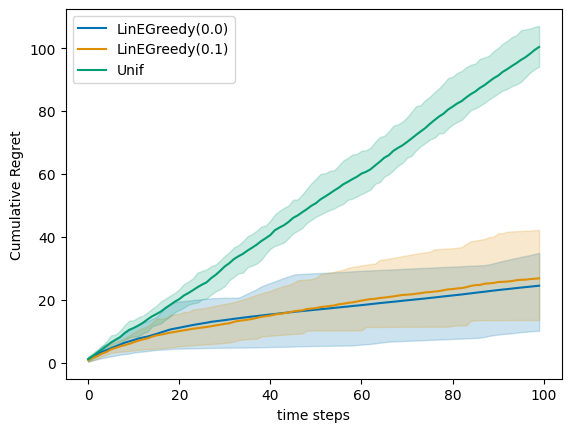

In [13]:
exp = experiment(env, [greedy, e_greedy, uniform], Nmc=N, T=T,pseudo_regret=True)
plot_regret(exp)

/var/folders/nk/rqbxbzbs6cx3djvmyg89hzhh0000gn/T/ipykernel_2086/3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


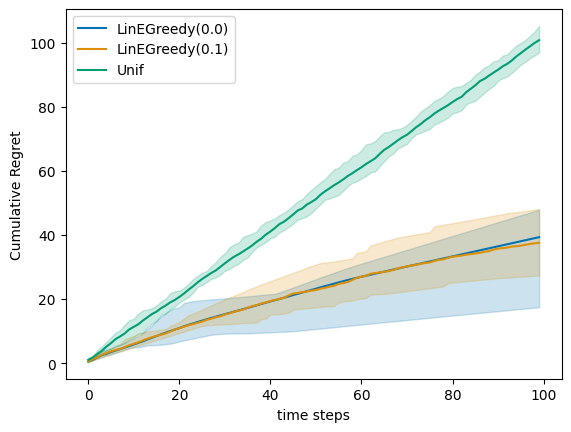

In [14]:
fixed_actions = ActionsGenerator(K, d)
fixed_env = LinearBandit(theta, K, var=sigma**2, fixed_actions = fixed_actions)

fixed_exp = experiment(fixed_env, [greedy, e_greedy, uniform], Nmc=N, T=T,pseudo_regret=True)
plot_regret(fixed_exp)

In [15]:
def exponential_decay(t, eps, decay_rate=0.99):
    return eps * (decay_rate ** t)

def linear_decay(t, eps, min_eps=0.01, decay_rate=0.001):
    return max(min_eps, eps - decay_rate * t)

def custom_decay(t, eps):
    return max(0.01, eps / (1 + 0.05 * t))

Is Lin-E-Greedy a strong baseline? Is it hard to beat?

In [16]:
uniform = LinUniform()
e_greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.1)
greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.)
e_greedy_exp_decay = LinEpsilonGreedy(d, lambda_reg=1., eps=0.3, epsilon_decay=exponential_decay)
e_greedy_lin_decay = LinEpsilonGreedy(d, lambda_reg=1., eps=0.3, epsilon_decay=linear_decay)
e_greedy_custom_decay = LinEpsilonGreedy(d, lambda_reg=1., eps=0.3, epsilon_decay=custom_decay)

/var/folders/nk/rqbxbzbs6cx3djvmyg89hzhh0000gn/T/ipykernel_2086/3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


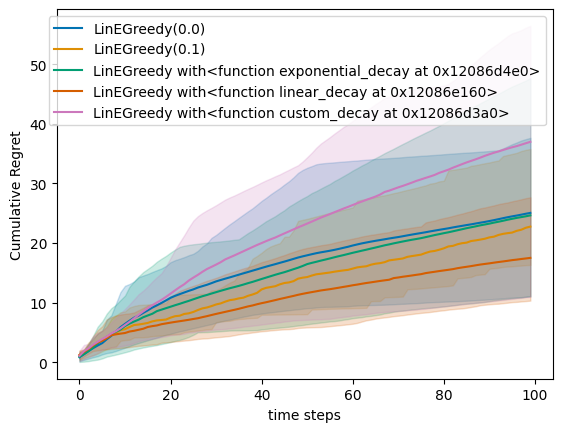

In [17]:
exp = experiment(env, [greedy, e_greedy, e_greedy_exp_decay, e_greedy_lin_decay, e_greedy_custom_decay], Nmc=N, T=T,pseudo_regret=True)
plot_regret(exp)

/var/folders/nk/rqbxbzbs6cx3djvmyg89hzhh0000gn/T/ipykernel_2086/3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


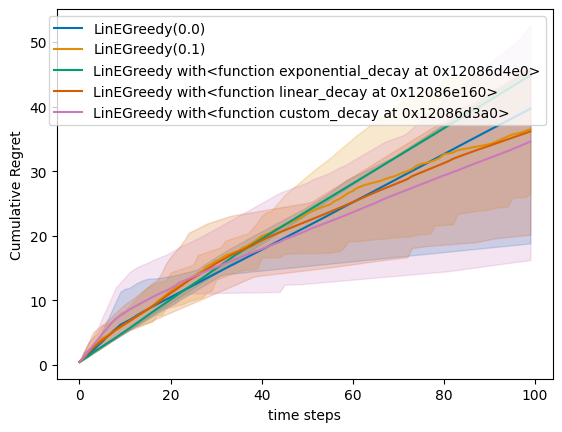

In [18]:
fixed_exp = experiment(fixed_env, [greedy, e_greedy, e_greedy_exp_decay, e_greedy_lin_decay, e_greedy_custom_decay], Nmc=N, T=T,pseudo_regret=True)
plot_regret(fixed_exp)

Discuss the complexity of the matrix inversion step and propose a better, incremental
update. Report the gain in runtimes that you observed as a function of d.

In [19]:
from numpy.linalg import pinv

class LinEpsilonGreedy_2:
  def __init__(self, d,lambda_reg, eps=0.1, epsilon_decay = None):
    self.eps = eps # exploration probability
    self.d = d
    self.lambda_reg = lambda_reg
    self.epsilon_decay = epsilon_decay
    self.reset()
    #use other inputs if needed

  def reset(self):
    """
    This function should reset all estimators and counts.
    It is used between independent experiments (see 'Play!' above)
    """
    self.t = 0
    self.hat_theta = np.zeros(self.d)
    self.cov = self.lambda_reg * np.identity(self.d)
    self.invcov = np.identity(self.d)
    self.b_t = np.zeros(self.d)

  def get_action(self, arms):

    if self.epsilon_decay is not None:
            self.eps = self.epsilon_decay(self.t, self.eps)
            
    K, _ = arms.shape
    u = np.random.rand()
    if u < self.eps:
      # Exploration: choose a random action
      return arms[np.random.choice(K)]
    else:
      # Exploitation: choose the action with maximum estimated reward
      estimated_rewards = arms @ self.hat_theta #empirical mean (exploitation term)
      return arms[np.argmax(estimated_rewards)]
    #return arms[np.random.choice(K)]

  def receive_reward(self, chosen_arm, reward):
    """
    update the internal quantities required to estimate the parameter theta using least squares
    """
    
    #update inverse covariance matrix
    #self.cov += np.outer(chosen_arm, chosen_arm)

    #chosen_arm = chosen_arm.reshape(-1, 1)  # Ensure column vector
    reshaped_chosen_arm = chosen_arm.reshape(-1, 1)
    denom = 1 + reshaped_chosen_arm.T @ self.invcov @ reshaped_chosen_arm
    self.invcov -= (self.invcov @ reshaped_chosen_arm @ reshaped_chosen_arm.T @ self.invcov) / denom
    #self.invcov = np.eye(self.d) #dummy instantiation: TODO

    #update b_t
    self.b_t += reward * chosen_arm

    self.hat_theta = np.inner(self.invcov, self.b_t) # update the least square estimate
    self.t += 1


  def name(self):
    if self.epsilon_decay is not None:
       return 'LinEGreedy with'+str(self.epsilon_decay)
    else:
       return 'LinEGreedy('+str(self.eps)+')'



In [20]:
import time

D = [2, 8, 16, 32, 64, 128]
K = 7
time_lineps1 = []
time_lineps2 = []

for d in D:
    theta = np.array([0.5]*d)
    theta /= np.linalg.norm(theta)
    env = LinearBandit(theta, K, var=sigma**2)
    e_greedy1 = LinEpsilonGreedy(d, lambda_reg=1., eps=0.1)
    e_greedy2 = LinEpsilonGreedy_2(d, lambda_reg=1., eps=0.1)
    
    debut = time.time()
    experiment(env, [e_greedy1], Nmc=N, T=T,pseudo_regret=True)
    fin = time.time()
    time_lineps1.append(fin-debut)
    debut = time.time()
    experiment(env, [e_greedy2], Nmc=N, T=T,pseudo_regret=True)
    fin = time.time() 
    time_lineps2.append(fin-debut)


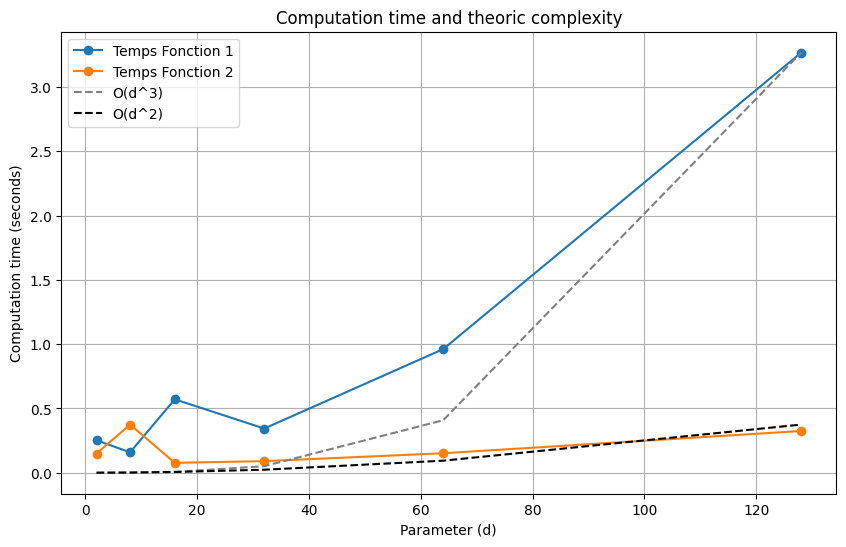

In [21]:
params_theorique = np.array(D)
complexite_O_d3 = params_theorique**3 / max(params_theorique**3) * max(time_lineps1)
complexite_O_d2 = params_theorique**2 / max(params_theorique**2) * max(time_lineps2)

# Créer le graphique
plt.figure(figsize=(10, 6))
plt.plot(D, time_lineps1, label='Temps Fonction 1', marker='o')
plt.plot(D, time_lineps2, label='Temps Fonction 2', marker='o')
plt.plot(params_theorique, complexite_O_d3, label='O(d^3)', linestyle='--', color='gray')
plt.plot(params_theorique, complexite_O_d2, label='O(d^2)', linestyle='--', color='black')

# Ajouter des labels et une légende
plt.xlabel('Parameter (d)')
plt.ylabel('Computation time (seconds)')
plt.title('Computation time and theoric complexity')
plt.legend()
plt.grid(True)

## Lin-UCB: The optimistic way

**Implement LinUCB** as seen in class and test it against the baselines implemented above.

If you are happy with the result, move to the last part below.


In [23]:

class LinUCB:
    def __init__(self, d, delta, sigma, lambda_reg=1.0):
        """
        LinUCB algorithm for linear contextual bandits.

        Parameters:
        - d: Dimension of the action space.
        - delta: Confidence level parameter (probability of error ≤ delta).
        - sigma: Standard deviation of the noise (sub-Gaussian assumption).
        - lambda_reg: Regularization parameter for the covariance matrix.
        """
        self.d = d  # Dimension of the feature space
        self.delta = delta  # Confidence level
        self.sigma = sigma  # Sub-Gaussian noise parameter
        self.lambda_reg = lambda_reg  # Regularization parameter
        self.reset()

    def reset(self):
        """
        Reset all internal estimators and counters for independent experiments.
        """
        self.t = 0  # Time step counter
        self.hat_theta = np.zeros(self.d)  # Estimated parameter vector
        self.cov = self.lambda_reg * np.identity(self.d)  # Covariance matrix (B_t)
        self.invcov = pinv(self.cov)  # Inverse of the covariance matrix
        self.b_t = np.zeros(self.d)  # Accumulated rewards vector

    def _beta_t(self):
        """
        Compute the exploration parameter beta_t.

        Returns:
        - beta_t: Exploration parameter.
        """
        #log_term = np.log((1 + self.t * self.d / self.lambda_reg) / self.delta)
        log_term = 2 * np.log(1 / self.delta) + self.d * np.log(1 + self.t * 1 / (self.d * self.lambda_reg)) #L = 1 bc of the action generator
        return(self.sigma * np.sqrt(log_term) + np.sqrt(self.lambda_reg))
        #return self.sigma * np.sqrt(2 * log_term) + np.sqrt(self.lambda_reg)

    def get_action(self, arms):
        """
        Choose an action using the LinUCB strategy.

        Parameters:
        - arms: Array of shape (K, d) representing the available actions.

        Returns:
        - The chosen action (vector of dimension d).
        """
        K, _ = arms.shape
        beta_t = self._beta_t()
        ucb_values = []

        for arm in arms:
            # Exploitation term: expected reward
            mean_reward = np.dot(arm, self.hat_theta)
            # Exploration term: confidence interval
            uncertainty = beta_t * np.sqrt(np.dot(arm, np.dot(self.invcov, arm)))
            # Upper Confidence Bound (UCB)
            ucb = mean_reward + uncertainty
            ucb_values.append(ucb)

        # Choose the action with the highest UCB
        best_arm_idx = np.argmax(ucb_values)
        return arms[best_arm_idx]

    def receive_reward(self, chosen_arm, reward):
        """
        Update the internal model with the observed reward for the chosen action.

        Parameters:
        - chosen_arm: The action (vector) that was chosen.
        - reward: The observed reward.
        """
        # Update covariance matrix and its inverse
        self.cov += np.outer(chosen_arm, chosen_arm)
        self.invcov = pinv(self.cov)

        # Update the b_t vector with the reward
        self.b_t += reward * chosen_arm

        # Update the least squares estimate of theta
        self.hat_theta = np.dot(self.invcov, self.b_t)
        self.t += 1

    def name(self):
        """
        Returns the name of the algorithm for identification.
        """
        return f'LinUCB(delta={self.delta}, sigma={self.sigma})'

### Test against baselines

In [27]:
# policies
K = 7
theta = np.array([0.45, 0.5, 0.5])
theta /= np.linalg.norm(theta)
d = 3

linucb = LinUCB(d, delta, sigma=sigma, lambda_reg=1.)
uniform = LinUniform()
e_greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.1)
greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.)


In [28]:
iid_env = LinearBandit(theta, K, var=sigma**2)

/var/folders/nk/rqbxbzbs6cx3djvmyg89hzhh0000gn/T/ipykernel_2086/3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


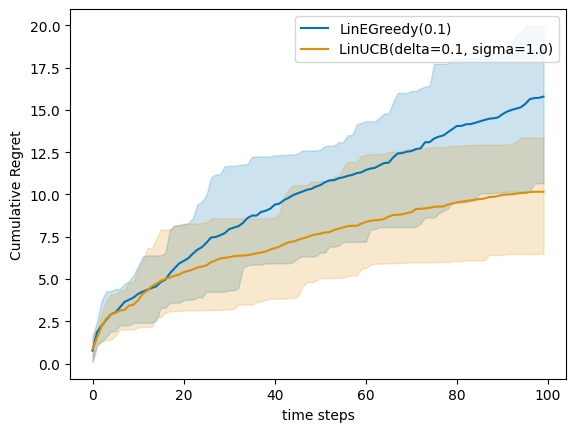

In [31]:
linucb_vs_greedy = experiment(iid_env, [e_greedy, linucb], Nmc=N, T=T,pseudo_regret=True)
plot_regret(linucb_vs_greedy)

## LinTS : Taking the Bayesian way

Thompson Sampling is a popular bayesian alternative to the standard optimistic bandit algorithms (see Chapter 36 of Bandit Algorithms). The key idea is to rely on Bayesian *samples* to get a proxy for the hidden parameter $\theta$ of the problem instead of building high-probability confidence regions.

* **Posterior derivation**: Let us place a Gaussian prior with mean $\mathbf{0}$ and covariance $\lambda I$ on $\theta$. Given actions $A_1,\ldots,A_t$ and rewards $Y_1,\ldots,Y_t$, Can you compute the expression of the posterior at the beginning of round $t+1$ ?

In your report, write the distribution of the posterior as a function of the prior and the observed data. No need to report your full derivation if you are lacking space.


* **Implementation of LinTS**. Please implement Linear Thompson Sampling using the formula you derived above.

In [ ]:
# class LinTS ... (use you LinUCB template)

class LinTS:
    def __init__(self, d, sigma, lambda_reg=1.0, alpha=1.0):
        """
        LinTS algorithm for linear contextual bandits.

        Parameters:
        - d: Dimension of the action space.
        - sigma: Standard deviation of the noise (assumes sub-Gaussian noise).
        - lambda_reg: Regularization parameter for the covariance matrix.
        - alpha: Scaling factor for exploration (optional, typically set to 1.0).
        """
        self.d = d  # Dimension of the feature space
        self.sigma = sigma  # Noise standard deviation
        self.lambda_reg = lambda_reg  # Regularization parameter
        self.alpha = alpha  # Exploration scaling factor
        self.reset()

    def reset(self):
        """
        Reset all internal estimators and counters for independent experiments.
        """
        self.t = 0  # Time step counter
        self.hat_theta = np.zeros(self.d)  # Estimated parameter vector
        self.cov = self.lambda_reg * np.identity(self.d)  # Covariance matrix (B_t)
        self.invcov = pinv(self.cov)  # Inverse of the covariance matrix
        self.b_t = np.zeros(self.d)  # Accumulated rewards vector

    def get_action(self, arms):
        """
        Choose an action using the LinTS strategy.

        Parameters:
        - arms: Array of shape (K, d) representing the available actions.

        Returns:
        - The chosen action (vector of dimension d).
        """
        # Sample a parameter vector from the posterior distribution
        posterior_mean = np.dot(self.invcov, self.b_t)
        posterior_cov = self.alpha * self.sigma**2 * self.invcov
        sampled_theta = np.random.multivariate_normal(posterior_mean, posterior_cov)

        # Compute the estimated reward for each arm using the sampled theta
        estimated_rewards = np.dot(arms, sampled_theta)

        # Choose the action with the highest estimated reward
        best_arm_idx = np.argmax(estimated_rewards)
        return arms[best_arm_idx]

    def receive_reward(self, chosen_arm, reward):
        """
        Update the internal model with the observed reward for the chosen action.

        Parameters:
        - chosen_arm: The action (vector) that was chosen.
        - reward: The observed reward.
        """
        # Update covariance matrix and its inverse
        self.cov += np.outer(chosen_arm, chosen_arm)
        self.invcov = pinv(self.cov)

        # Update the b_t vector with the reward
        self.b_t += reward * chosen_arm

        # Update the least squares estimate of theta
        self.hat_theta = np.dot(self.invcov, self.b_t)
        self.t += 1

    def name(self):
        """
        Returns the name of the algorithm for identification.
        """
        return f'LinTS(alpha={self.alpha})'

Autre implementation : selon les calculs du latex (et pas comme dans les slides):

In [ ]:
# class LinTS ... (use you LinUCB template)

class LinTS:
    def __init__(self, d, sigma, lambda_reg=1.0, alpha=1.0):
        """
        LinTS algorithm for linear contextual bandits.

        Parameters:
        - d: Dimension of the action space.
        - sigma: Standard deviation of the noise (assumes sub-Gaussian noise).
        - lambda_reg: Regularization parameter for the covariance matrix.
        - alpha: Scaling factor for exploration (optional, typically set to 1.0).
        """
        self.d = d  # Dimension of the feature space
        self.sigma = sigma  # Noise standard deviation
        self.lambda_reg = lambda_reg  # Regularization parameter
        self.alpha = alpha  # Exploration scaling factor
        self.reset()

    def reset(self):
        """
        Reset all internal estimators and counters for independent experiments.
        """
        self.t = 0  # Time step counter
        self.hat_theta = np.zeros(self.d)  # Estimated parameter vector
        self.cov = 1/self.lambda_reg * np.identity(self.d)  # Covariance matrix (B_t)
        self.invcov = pinv(self.cov)  # Inverse of the covariance matrix
        self.b_t = np.zeros(self.d)  # Accumulated rewards vector

    def get_action(self, arms):
        """
        Choose an action using the LinTS strategy.

        Parameters:
        - arms: Array of shape (K, d) representing the available actions.

        Returns:
        - The chosen action (vector of dimension d).
        """
        # Sample a parameter vector from the posterior distribution
        sampled_theta = np.random.multivariate_normal(self.hat_theta, self.invcov)
        estimated_rewards = np.dot(arms, sampled_theta)
        best_arm_idx = np.argmax(estimated_rewards) # Choose the action with the highest estimated reward
        return arms[best_arm_idx]

    def receive_reward(self, chosen_arm, reward):
        """
        Update the internal model with the observed reward for the chosen action.

        Parameters:
        - chosen_arm: The action (vector) that was chosen.
        - reward: The observed reward.
        """
        # Update covariance matrix and its inverse
        self.cov += 1/self.sigma**2*np.outer(chosen_arm, chosen_arm)
        self.invcov = pinv(self.cov)

        # Update the b_t vector with the reward
        self.b_t += 1/self.sigma**2*(reward * chosen_arm)

        # Update the least squares estimate of theta
        self.hat_theta = np.dot(self.invcov, self.b_t)
        self.t += 1

    def name(self):
        """
        Returns the name of the algorithm for identification.
        """
        return f'LinTS(alpha={self.alpha})'

In [33]:
# policies

linucb = LinUCB(d, delta, sigma=sigma, lambda_reg=1.)
uniform = LinUniform()
e_greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.1)
greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.)
linTS = LinTS(d, sigma, lambda_reg=1.0, alpha=1.0)

### Comparison and report

Compare LinUCB, LinTS and LinEGreedy on a problem of your choice. In your report, explain your choice of problem and report the plot of your experiment as well as a few sentences of comment: Is there a clear 'winner'?

/var/folders/nk/rqbxbzbs6cx3djvmyg89hzhh0000gn/T/ipykernel_2086/3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


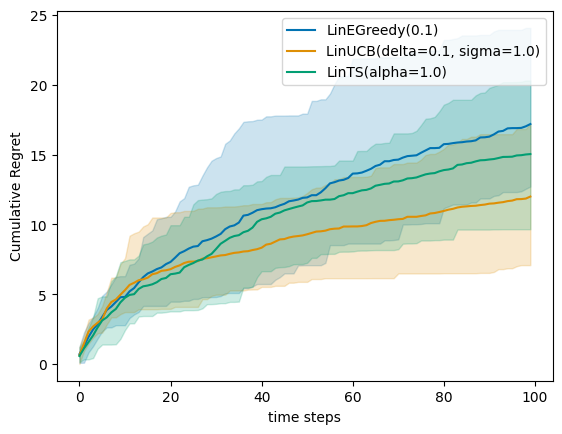

In [34]:
linucb_vs_greedy = experiment(iid_env, [e_greedy, linucb, linTS], Nmc=N, T=T,pseudo_regret=True)
plot_regret(linucb_vs_greedy)

## Comparison

In [51]:
D=[3, 64, 128]
K=[5, 100, 1000, 5000] # same as before, more actions than dimension

In [52]:
time_linucb = np.zeros((len(D), len(K)))
time_lints = np.zeros((len(D), len(K)))
time_linegreedy = np.zeros((len(D), len(K)))
perf_linucb = {}
perf_lints = {}
perf_linegreedy = {}

for i in range(len(D)):
    d = D[i]
    for j in range(len(K)):
        k = K[j]
        theta = np.array([0.5]*d)
        theta /= np.linalg.norm(theta)
        env = LinearBandit(theta, k, var=sigma**2)
        e_greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.1)
        lin_ucb = LinUCB(d, delta, sigma=sigma, lambda_reg=1.)
        lin_TS = LinTS(d, sigma, lambda_reg=1.0, alpha=1.0)
        
        debut = time.time()
        exp_ucb = experiment(env, [lin_ucb], Nmc=N, T=T,pseudo_regret=True)
        fin = time.time()
        perf_linucb[(i,j)] = exp_ucb
        time_linucb[i,j] = fin - debut

        debut = time.time()
        exp_ts = experiment(env, [lin_TS], Nmc=N, T=T,pseudo_regret=True)
        fin = time.time() 
        perf_lints[(i,j)] = exp_ts
        time_lints[i,j] = fin - debut

        debut = time.time()
        exp_ts = experiment(env, [e_greedy], Nmc=N, T=T,pseudo_regret=True)
        fin = time.time() 
        perf_linegreedy[(i,j)] = exp_ts
        time_linegreedy[i,j] = fin - debut

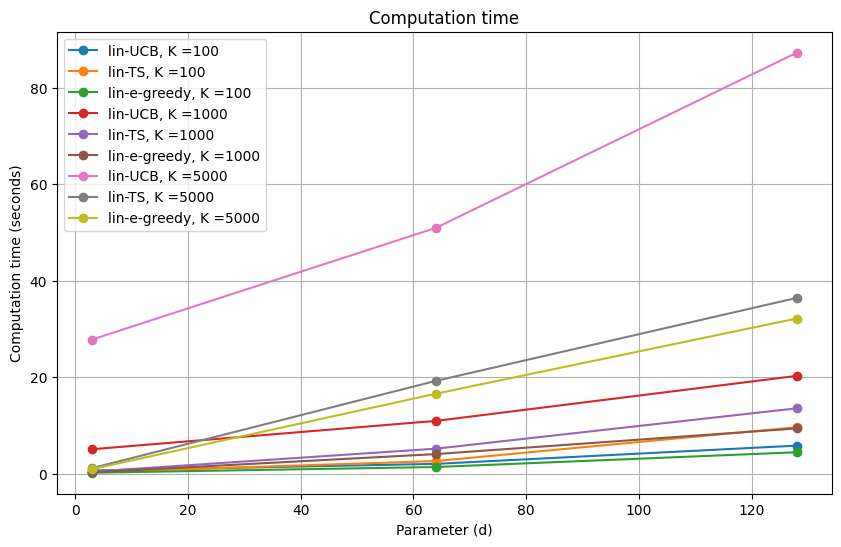

In [61]:
params_theorique = np.array(D)
complexite_O_d3 = params_theorique**3 / max(params_theorique**3) * max(time_lineps1)
complexite_O_d2 = params_theorique**2 / max(params_theorique**2) * max(time_lineps2)

# Créer le graphique
plt.figure(figsize=(10, 6))

for j in range(1,len(K)):
    plt.plot(D, time_linucb[:,j], label='lin-UCB, K =' + str(K[j]), marker='o')
    plt.plot(D, time_lints[:,j], label='lin-TS, K =' + str(K[j]), marker='o')
    plt.plot(D, time_linegreedy[:,j], label='lin-e-greedy, K =' + str(K[j]), marker='o')

# Ajouter des labels et une légende
plt.xlabel('Parameter (d)')
plt.ylabel('Computation time (seconds)')
plt.title('Computation time')
plt.legend()
plt.grid(True)

#Bonus

In this bonus part, we explore the role of the action sets on the performance of our algorithms.

In class we said that action sets can be 'arbitrary'. This means that, in principle, they do not have to follow a distribution, they do not have to be random either.

What happens if the action set is fixed?

We propose an alternative 'play' function that fixes the action set:

In [66]:
def play_fixed(environment, agent, Nmc, T, actions=None, pseudo_regret=True):
    """
    Play one Nmc trajectories over a horizon T for the specified agent.
    Return the agent's name (sring) and the collected data in an nd-array.
    actions: a fixed action set. Default is set to be the canonical basis.
    """

    data = np.zeros((Nmc, T))

    for n in range(Nmc):
        agent.reset()
        for t in range(T):
            # action_set = environment.get_action_set() -> We no longer call on your ActionsGenerator function
            action_set = np.copy(actions) # the actions given as input
            action = agent.get_action(action_set)
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)

            # compute instant (pseudo) regret
            means = environment.get_means()
            best_reward = np.max(means)
            if pseudo_regret:
              data[n,t] = best_reward - np.dot(environment.theta,action)
            else:
              data[n,t]= best_reward - reward # this can be negative due to the noise, but on average it's positive

    return agent.name(), data

In [70]:
def experiment_fixed(environment, agents, Nmc, T, actions=None, pseudo_regret=True):
    """
    Play Nmc trajectories for all agents over a horizon T. Store all the data in a dictionary.
    """

    all_data = {}
    if actions is None:
      actions = ActionsGenerator(K,d) #call it once!
    print(actions)

    for agent in agents:
        agent_id, regrets = play_fixed(environment, agent, Nmc, T, actions=actions, pseudo_regret=pseudo_regret)

        all_data[agent_id] = regrets

    return all_data

Now the actions are fixed, so we could actually use UCB to address the problem: after all, it is just a K-armed bandit, but with structure.

**When is LinUCB better than UCB?**

In [71]:
class UCB:
  def __init__(self, K, var):
      self.K = K
      self.var = var
      self.count_actions = np.zeros(self.K)
      self.count_rewards = np.zeros(self.K)
      self.t = 0

  def get_action(self,action_set):
      if self.t < self.K:
        action = self.t
      else:
        empirical_means = self.count_rewards / self.count_actions
        ucbs = np.sqrt(6 * self.var * np.log(self.t) / self.count_actions) # 6 could be replaced by a 2, try it out :)
        action = np.argmax(empirical_means + ucbs)

      self.t += 1
      self.count_actions[action] += 1
      self.current_action = action #need to remember the *index* of the action now
      return action_set[action,:]

  def receive_reward(self, action, reward):
      self.count_rewards[self.current_action] += reward

  def reset(self):
      self.count_actions = np.zeros(self.K)
      self.count_rewards = np.zeros(self.K)
      self.t = 0

  def name(self):
      return 'UCB('+str(self.var)+')'

In [72]:
d=3
K=7 # same as before, more actions than dimension

env = LinearBandit(theta, K)
ucb = UCB(K,var=1.)
linucb = LinUCB(d, delta=0.01, lambda_reg=1., sigma=1. )
reg_fixed_actions = experiment_fixed(env, [ucb, linucb], Nmc=10, T=200, actions=None, pseudo_regret=True)

[[-0.46938344 -0.29203775 -0.83330255]
 [ 0.85450773  0.51744238 -0.04549645]
 [ 0.98731207 -0.11565687  0.10880424]
 [-0.22349963 -0.01486786  0.97459061]
 [-0.74619645  0.66543199  0.01977683]
 [-0.71748599  0.61492638  0.32722989]
 [ 0.6485868   0.15836456 -0.7444836 ]]


/var/folders/nk/rqbxbzbs6cx3djvmyg89hzhh0000gn/T/ipykernel_1080/3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


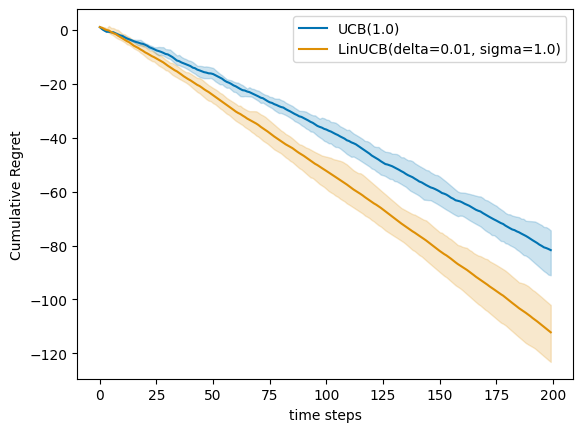

In [73]:
plot_regret(reg_fixed_actions)

In general, LinUCB is better in such problem because it shares information across actions.

Now, what if K=d and the fixed action set is exactly the canonical basis (K=d independent actions)

In [74]:
d=7
K=d
# theta = np.random.multivariate_normal(np.zeros(d),np.eye(d))
theta = np.linspace(0.1,1,num=d) # just d actions in increasing value order
#theta = your choice of parameter
theta /= np.linalg.norm(theta) #optional if you set theta with bounded norm :)

env = LinearBandit(theta, d, fixed_actions=np.eye(d))
ucb = UCB(d,var=1.)
linucb = LinUCB(d, delta=0.01, lambda_reg=1., sigma=1. )
reg_fixed_actions = experiment_fixed(env, [ucb, linucb], Nmc=10, T=200, actions=np.eye(d), pseudo_regret=True)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
plot_regret(reg_fixed_actions)

The two algorithms should be roughly on par. In fact, it is possible to refine UCB to get slightly better performance (by tightening a bit the upper confidence bounds).

In "[The End of Optimism](https://arxiv.org/pdf/1610.04491)", Lattimore et al. show that for a certain type of action set, one can show that UCB has **linear regret**. A famous 'counter-example' (bad action set) is given in Section 8 therein.

**Exercise**: find the action set (3 actions in dimension 2) and run the experiment above, what do you see? In (the appendix of) your report, please report your figures and conclusions.

The problem of finding a good algorithm for the 'arbitrary' setting and the 'fixed-design' setting was open for a long time but recent papers (e.g. [Kirschner et al.,2021](https://arxiv.org/abs/2011.05944)) have now proposed solutions.